In [ ]:
import json
import openml
from scipy.stats import ttest_rel, rankdata
import lightgbm as lgb
from src import DataBinner
import numpy as np

num_datasets_class = 16
num_datasets_reg = 18

num_seeds = 20
model = 'SKL'

reg_benchmark_suite = openml.study.get_suite(336)
class_benchmark_suite = openml.study.get_suite(337)  # 337 for classification

#We want to be ranking across datasets within each model type
mrr_reg = {'quantile': [], 'linspace': [], 'kmeans': []}
mrr_class = {'quantile': [], 'linspace': [], 'kmeans': []}
mrr_total = {'quantile': [], 'linspace': [], 'kmeans': []}
    
def bold_if_sig(best_val, best_arr, second_val, second_arr):
    """Return '{best_val:.5f}' or '\\textbf{...}' depending on p-value."""
    p_val = ttest_rel(best_arr, second_arr).pvalue
    formatted = f"${best_val:.3f}$"

    if p_val < 0.05:
        return f"${formatted}\\mathrlap{{^{{**}}}}$"
    elif p_val < 0.1:
        return f"${formatted}\\mathrlap{{^{{*}}}}$"
    else:
        return formatted

#Classification first
print("DATA FOR CLASSIFICATION")
for idx in range(num_datasets_class):
    if idx not in [2, 8]:
        task_id = class_benchmark_suite.tasks[idx]
        task = openml.tasks.get_task(task_id)
        dataset = task.get_dataset()
        name = dataset.name
        name = name.replace("_", "\_")
        obs = dataset.qualities['NumberOfInstances']
        features = dataset.qualities['NumberOfFeatures']

        with open(f"class_results_binning_{idx}.json", "r") as f:
            results = json.load(f)
            linspace_dict = results['linspace']
            quantile_dict = results['quantile'] 
            kmeans_dict = results['kmeans']
            exact_dict = results['exact']

        kmeans_results = kmeans_dict[model]['roc_auc']
        linspace_results = linspace_dict[model]['roc_auc']
        quantile_results = quantile_dict[model]['roc_auc']
        exact_results = exact_dict[model]['roc_auc']

        kmeans_mean = np.mean(kmeans_results)
        linspace_mean = np.mean(linspace_results)
        quantile_mean = np.mean(quantile_results)
        exact_mean = np.mean(exact_results)
        
        # Calculating MRR within this dataset -- DO NOT include exact here
        results = {'kmeans': kmeans_results, 'linspace': linspace_results, 'quantile': quantile_results}
        means = {method: np.mean(results[method]) for method in results}
        rank_list = list(means.values())
        ranks = {method: rank for method, rank in zip(means.keys(), rankdata(-1 * np.array(rank_list)))}
        
        # Get inverse ranks
        inv_ranks = {method: 1 / rank for method, rank in ranks.items()}
        
        for method in results.keys():
            mrr_class[method].append(inv_ranks[method])
            mrr_total[method].append(inv_ranks[method])

        # ------------------------------------------------------------
        # Find best / second-best (lower MSE = better) and format cells
        # ------------------------------------------------------------
        sorted_methods = sorted(means, key=means.get, reverse = True)          # best first
        best, second = sorted_methods[:2]

        fmt = {}                                              # holds strings to print
        for m in ['quantile', 'linspace', 'kmeans']:
            if m == best:                                     # winner – maybe bold
                fmt[m] = bold_if_sig(means[m],
                                    results[m],              # arrays for t-test
                                    means[second],
                                    results[second])
            else:                                             # plain number
                fmt[m] = f"{(means[m]):.3f}"
                
        print(f"{name} & {fmt['quantile']} & {fmt['linspace']} & {fmt['kmeans']} & {exact_mean:.3f} \\\\")

    
#Dictionary that we put our final rankings in
mrr_class_avg = {method: np.mean(mrr_class[method]) for method in ['quantile', 'linspace', 'kmeans']}
        

# MRR for Classification
print("%% Mean Reciprocal Rank (MRR) Table for Classification")
print("\\begin{table}[htbp]")
print("    \\centering")
print("    \\caption{Mean Reciprocal Rank (MRR) for each binning method computed within each baseline algorithm based on MSE performance for Regression datasets. Lower MSE yields a better (lower) rank, and the inverse rank is averaged across datasets.}")
print("    \\label{tab:mrr_class}")
print("    \\begin{tabular}{lccc}")
print("        \\toprule")
print("        Baseline & Quantile & Uniform & K-Means \\\\")
print("        \\midrule")
print(f"        \\textbf{{Classification}} & {mrr_class_avg['quantile']:.2f} & {mrr_class_avg['linspace']:.2f} & {mrr_class_avg['kmeans']:.2f} & \\\\")
print("        \\bottomrule")
print("    \\end{tabular}")
print("\\end{table}")


#Regression
print("DATA FOR REGRESSION")
for idx in range(num_datasets_reg):
    task_id = reg_benchmark_suite.tasks[idx]
    task = openml.tasks.get_task(task_id)
    dataset = task.get_dataset()
    name = dataset.name
    name = name.replace("_", "\_")
    obs = dataset.qualities['NumberOfInstances']
    features = dataset.qualities['NumberOfFeatures']

    with open(f"reg_results_binning_{idx}.json", "r") as f:
        results = json.load(f)
        linspace_dict = results['linspace']
        quantile_dict = results['quantile'] 
        kmeans_dict = results['kmeans']
        exact_dict = results['exact']

    kmeans_results = kmeans_dict[model]['mse']
    linspace_results = linspace_dict[model]['mse']
    quantile_results = quantile_dict[model]['mse']
    exact_results = exact_dict[model]['mse']

    kmeans_mean = np.mean(kmeans_results)
    #Find correct value for exponent for scientific notation
    exponent = int(np.floor(np.log10(kmeans_mean)))
    divisor = 10 ** exponent
    
    linspace_mean = np.mean(linspace_results)
    quantile_mean = np.mean(quantile_results)
    exact_mean = np.mean(exact_results)
    
    # Calculating MRR within this dataset -- DO NOT include exact here
    results = {'kmeans': kmeans_results, 'linspace': linspace_results, 'quantile': quantile_results}
    means = {method: np.mean(results[method]) for method in results}
    ranks = {method: rank for method, rank in zip(means.keys(), rankdata(list(means.values())))}
    
    # Get inverse ranks
    inv_ranks = {method: 1 / rank for method, rank in ranks.items()}
    
    for method in results.keys():
        mrr_reg[method].append(inv_ranks[method])
        mrr_total[method].append(inv_ranks[method])

    # ------------------------------------------------------------
    # Find best / second-best (lower MSE = better) and format cells
    # ------------------------------------------------------------
    sorted_methods = sorted(means, key=means.get)          # best first
    best, second = sorted_methods[:2]

    fmt = {}                                              # holds strings to print
    for m in ['quantile', 'linspace', 'kmeans']:
        if m == best:                                     # winner – maybe bold
            fmt[m] = bold_if_sig(means[m] / divisor,
                                  results[m],              # arrays for t-test
                                  means[second] / divisor,
                                  results[second])
        else:                                             # plain number
            fmt[m] = f"{(means[m] / divisor):.3f}"
            
    print(f"{name} $(10^{{{exponent}}})$ & {fmt['quantile']} & {fmt['linspace']} & {fmt['kmeans']} & {(exact_mean / divisor) :.3f} \\\\")
    
#Dictionary that we put our final rankings in
mrr_reg_avg = {method: np.mean(mrr_reg[method]) for method in ['quantile', 'linspace', 'kmeans']}


# MRR for Regression
print("%% Mean Reciprocal Rank (MRR) Table for Regression")
print("\\begin{table}[htbp]")
print("    \\centering")
print("    \\caption{Mean Reciprocal Rank (MRR) for each binning method computed within each baseline algorithm based on MSE performance for Regression datasets. Lower MSE yields a better (lower) rank, and the inverse rank is averaged across datasets.}")
print("    \\label{tab:mrr_reg}")
print("    \\begin{tabular}{lccc}")
print("        \\toprule")
print("        Baseline & Quantile & Uniform & K-Means \\\\")
print("        \\midrule")
print(f"        \\textbf{{Regression}} & {mrr_reg_avg['quantile']:.2f} & {mrr_reg_avg['linspace']:.2f} & {mrr_reg_avg['kmeans']:.2f} & \\\\")
print("        \\bottomrule")
print("    \\end{tabular}")
print("\\end{table}")

#TOTAL!
#Dictionary that we put our final rankings in
mrr_total_avg = {method: np.mean(mrr_total[method]) for method in ['quantile', 'linspace', 'kmeans']}
print("TOTAL DATA")
# MRR for Regression
print("%% Mean Reciprocal Rank (MRR) Table for All")
print("\\begin{table}[htbp]")
print("    \\centering")
print("    \\caption{Mean Reciprocal Rank (MRR) for each binning method over all datasets}")
print("    \\label{tab:mrr_reg}")
print("    \\begin{tabular}{lccc}")
print("        \\toprule")
print("        Baseline & Quantile & Uniform & K-Means \\\\")
print("        \\midrule")
print(f"        \\textbf{{Total}} & {mrr_total_avg['quantile']:.2f} & {mrr_total_avg['linspace']:.2f} & {mrr_total_avg['kmeans']:.2f} & \\\\")
print("        \\bottomrule")
print("    \\end{tabular}")
print("\\end{table}")




In [ ]:
import json
import openml
from scipy.stats import ttest_rel, rankdata
import lightgbm as lgb
from src import DataBinner
import numpy as np

num_datasets_class = 16
num_datasets_reg = 18

num_seeds = 20
model = 'SKL'

reg_benchmark_suite = openml.study.get_suite(336)
class_benchmark_suite = openml.study.get_suite(337)  # 337 for classification

print("Classification")
class_frac = []
for idx in range(num_datasets_class):
    task_id = class_benchmark_suite.tasks[idx]
    task = openml.tasks.get_task(task_id)
    dataset = task.get_dataset()
    name = dataset.name

    X, y = task.get_X_and_y(dataset_format='dataframe')
    cols_with_255_unique = 0
    skews = []
    for col in X.columns:
        if len(X[col].unique()) >= 255:
            skews.append(X[col].skew())
            cols_with_255_unique += 1
    class_frac.append(cols_with_255_unique / len(X.columns))
    print(f"Dataset: {name}, fraction of features with 255 unique values: {cols_with_255_unique / len(X.columns):.2f}, skew: {np.mean(skews):.2f}")
    
print("Regression")
reg_frac = []
for idx in range(num_datasets_reg):
    task_id = reg_benchmark_suite.tasks[idx]
    task = openml.tasks.get_task(task_id)
    dataset = task.get_dataset()
    name = dataset.name
    
    X, y = task.get_X_and_y(dataset_format='dataframe')
    cols_with_255_unique = 0
    skews = []
    for col in X.columns:
        if len(X[col].unique()) >= 255:
            skews.append(X[col].skew())
            cols_with_255_unique += 1
    reg_frac.append(cols_with_255_unique / len(X.columns))
    print(f"Dataset: {name}, fraction of features with 255 unique values: {cols_with_255_unique / len(X.columns):.2f}, skew: {np.mean(skews):.2f}")
    
print(np.mean(reg_frac), np.mean(class_frac))

Dataset name:  credit


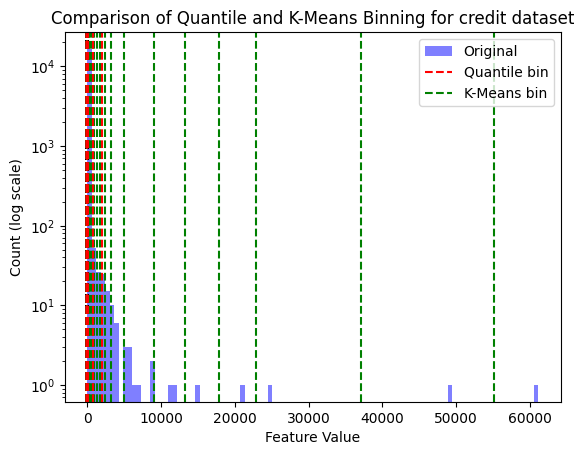

/Users/asherlabovich/Documents/HistBinningLGBM/HistMethods/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: AutoMinorLocator does not work on logarithmic scales
  fig.canvas.print_figure(bytes_io, **kw)


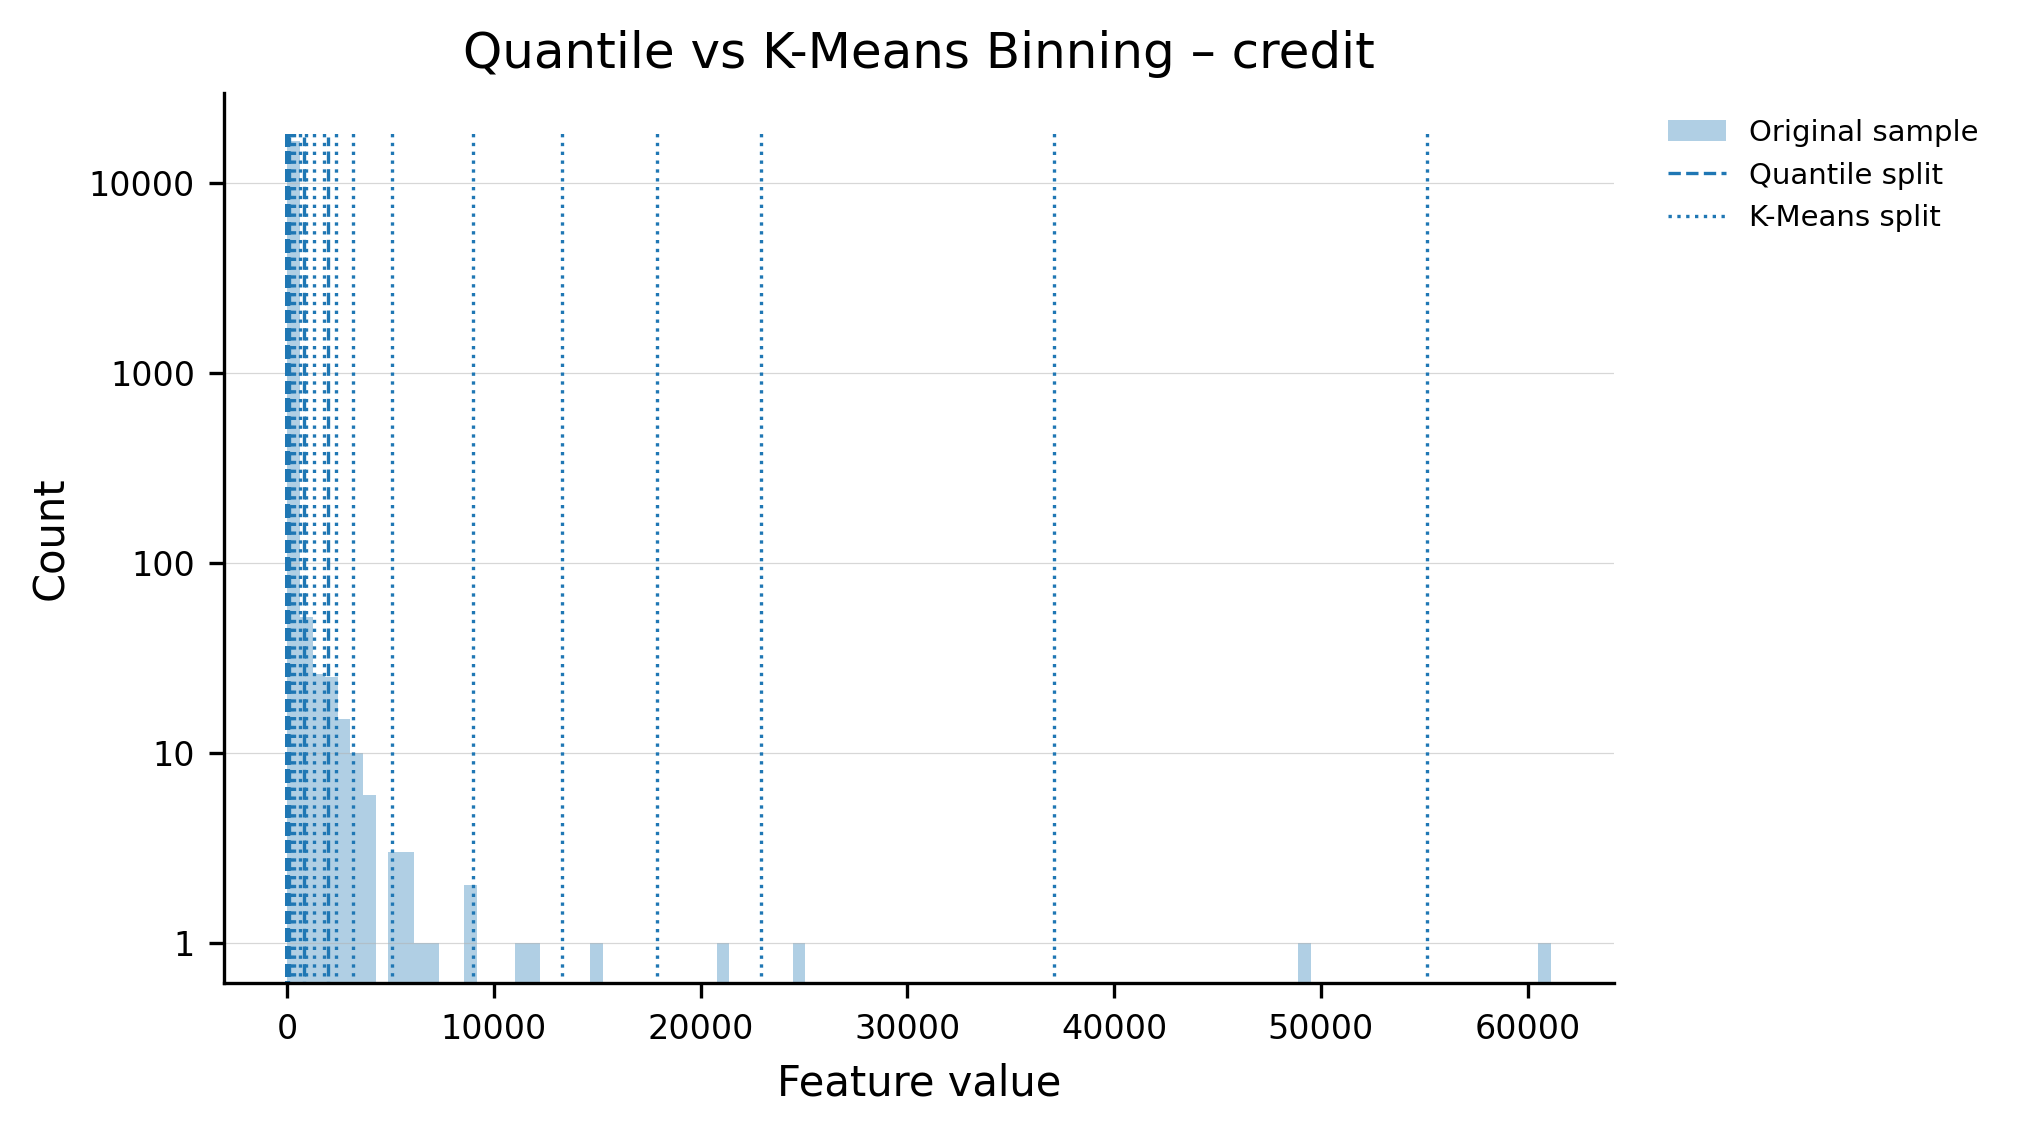

In [16]:
import matplotlib.pyplot as plt

reg_benchmark_suite = openml.study.get_suite(336)
class_benchmark_suite = openml.study.get_suite(337)  # 337 for classification

dataset_idx = 0
col_idx = 3
task_id = class_benchmark_suite.tasks[dataset_idx]
task = openml.tasks.get_task(task_id)
dataset = task.get_dataset()
name = dataset.name
print("Dataset name: ", name)

X, y = task.get_X_and_y(dataset_format='dataframe')
quantile_binner = DataBinner(method='quantile', n_bins=255)
kmeans_binner = DataBinner(method='kmeans', n_bins=255)

X_q, X_k = quantile_binner.fit_transform(X), kmeans_binner.fit_transform(X)
splits_q, splits_k = quantile_binner._models, kmeans_binner._models

X_0 = X.iloc[:, col_idx]
splits_q = splits_q[col_idx]
splits_k = splits_k[col_idx]

#Create graph comparing the two binning methods
plt.hist(X_0, bins = 100, alpha = 0.5, label = "Original", color = "blue")
plt.axvline(x = splits_q[0], color = "red", linestyle = "--", label = f"Quantile bin")
plt.axvline(x = splits_k[0], color = "green", linestyle = "--", label = f"K-Means bin")
for i in range(1, 254):
    plt.axvline(x = splits_q[i], color = "red", linestyle = "--")
    plt.axvline(x = splits_k[i], color = "green", linestyle = "--")
plt.legend()
plt.title(f"Comparison of Quantile and K-Means Binning for {name} dataset")
plt.yscale('log')
plt.xlabel("Feature Value")
plt.ylabel("Count (log scale)")
plt.show()

import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter, AutoMinorLocator

# ----- Figure and axes -------------------------------------------------------
fig, ax = plt.subplots(figsize=(5.2, 3.4), dpi=300)     # journal-friendly size
fig.tight_layout(pad=0.5)

# ----- Histogram of the raw feature ------------------------------------------
ax.hist(
    X_0,
    bins=100,
    histtype="stepfilled",
    alpha=0.35,               # subtle fill so grid & lines stay visible
    label="Original sample",
)

# ----- Vertical bin-edge markers ---------------------------------------------
#   Draw only every n-th edge to cut visual clutter (adjust n as you like)
show_every = 1

# quantile
ax.vlines(
    splits_q[::show_every],
    ymin=0, ymax=ax.get_ylim()[1],
    linestyles="--",
    linewidth=0.8,
    label="Quantile split",
)

# k-means
ax.vlines(
    splits_k[::show_every],
    ymin=0, ymax=ax.get_ylim()[1],
    linestyles="dotted",
    linewidth=0.8,
    label="K-Means split",
)

# ----- Aesthetics -------------------------------------------------------------
ax.set(
    title=f"Quantile vs K-Means Binning – {name}",
    xlabel="Feature value",
    ylabel="Count",
    yscale="log",
)

# thin logarithmic grid
ax.yaxis.set_minor_locator(AutoMinorLocator())
ax.grid(which="both", axis="y", linewidth=0.3, alpha=0.5)

# compact scientific notation on y-axis ticks
ax.yaxis.set_major_formatter(ScalarFormatter())
ax.tick_params(axis="both", which="major", labelsize=8)

# legend outside so it never hides data
ax.legend(frameon=False, fontsize=7, loc="upper left", bbox_to_anchor=(1.02, 1))

# remove right/top spines – cleaner look
for spine in ("right", "top"):
    ax.spines[spine].set_visible(False)

plt.show()



In [18]:
arr = np.array([
    [2.34025018e-03, 2.68516736e-03, 2.91038333e-01, 1.14710000e-02],
    [4.03433386e-03, 5.76483412e-03, 1.95374792e-01, 1.70915420e-02],
    [7.70583376e-03, 1.11124581e-02, 4.39384000e-01, 3.11319577e-02],
    [1.17213749e-02, 1.69383343e-02, 6.81859917e-01, 4.40294999e-02],
    [1.67215001e-02, 2.29464169e-02, 9.21933250e-01, 6.42237077e-02],
    [4.12364579e-02, 5.75064579e-02, 2.34334212e+00, 1.37501209e-01],
    [8.41062921e-02, 1.16463083e-01, 4.72721458e+00, 2.89728750e-01],
    [1.30993958e-01, 1.80439959e-01, 7.56789163e+00, 3.71964333e-01],
    [1.71991500e-01, 2.35597500e-01, 9.34137783e+00, 5.06569750e-01],
    [4.85310125e-01, 6.08407166e-01, 2.22046197e+01, 1.27593375e+00],
    [9.20843833e-01, 1.24926146e+00, 4.37326607e+01, 2.48749692e+00],
    [1.40358863e+00, 1.88061304e+00, 6.66191313e+01, 3.79564600e+00],
    [1.90011063e+00, 2.55894788e+00, 8.82418369e+01, 5.10267646e+00]
])

print(np.mean(arr, axis = 0))

[ 0.39851575  0.53436029 19.02366654  1.08734345]
